## Análise: Dados Experimentais da Radiação de Corpo Negro

#### Importar dados

In [1]:
import pandas as pd

df = [pd.read_csv('processed_data/s'+str(i)+'.csv', decimal=',', header=1)
    for i in range(1,6)]
df[0].head()

,θ ( graus ),θ rad,λ (metros),"Intensidade de luz, canal A ( % do máx. )"
0,0.0,0.0,0.0,290.1
1,0.0,0.0,0.0,291.4
2,0.0,0.0,0.0,290.5
3,0.0,0.0,0.0,289.5
4,0.0,0.0,0.0,292.8


#### Definir comprimento de onda e intensidade de luz

In [2]:
comp = [df[i][df[i].columns[2]] for i in range(0,5)]
ints = [df[i][df[i].columns[3]] for i in range(0,5)]

#### Plotar gráfico de intensidade x comprimento de onda

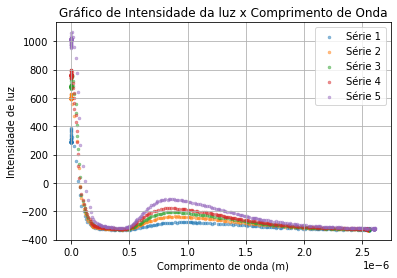

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.gcf()

for i in range(0,5):
    plt.scatter(comp[i], ints[i], label='Série '+str(i+1), 
               marker='.', lw=0.5, alpha=0.5)

plt.title('Gráfico de Intensidade da luz x Comprimento de Onda')
plt.xlabel('Comprimento de onda (m)')
plt.ylabel('Intensidade de luz')
plt.legend()
plt.grid()
plt.show()
fig.savefig('fig.png', bbox_inches='tight')

#### Ajustar a curva de Planck

Função: $\rho_T (\lambda) d\lambda = n \frac{8 \pi h c}{\lambda^5} \frac{1}{exp(\frac{hc}{\lambda k T})-1} d\lambda + m$

Onde $\rho_T$ é a função de radiância em função da temperatura, $\lambda$ é o comp. de onda, $n$ é uma normalização, $h$ é a constante de Planck, $c$ é a velocidade da luz, $k$ é a constante de Boltzmann, e $m$ é a constante de fundo..

Chutes iniciais: \
$n = 1$ \
$h = 6.6e-34 $ \
$k = 1.38e-23$ \
$T = 2000$ \
$m = -325 $

In [4]:
# Definir dados desconsiderando lambda = 0
xdata = [df[i][df[i][df[i].columns[2]]!=0].reset_index()[df[i].columns[2]]
         for i in range(0,5)]
y = [df[i][df[i][df[i].columns[2]]!=0].reset_index()[df[i].columns[3]]
     for i in range(0,5)]

In [5]:
# Definir função
import numpy as np

def planck_curve(x, n, m, T, k, h):
    c=3*10**8
    return ((n*(8*np.pi*h*c) / (x**5)) * (1 / (np.exp((h*c)/(x*k*T)) - 1))) - m

In [6]:
# Realizar ajuste
from scipy.optimize import curve_fit

init = [1, -325, 2000, 1.38e-23, 6.6e-34]
params = [curve_fit(f=planck_curve, xdata=xdata[i], ydata=y[i], p0=init)[0]
for i in range(0,5)]

C:\Users\leona\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Parâmetros encontrados:

In [7]:
for i in range(0,5):
    print(
        'Série', i+1, ':\n'
        ' n:', params[i][0], '\n',
        'm:', params[i][1], '\n',
        'T:', params[i][2], '\n',
        'k:', params[i][3], '\n',
        'h:', params[i][4], '\n',
    )

Série 1 :
 n: -0.10950558925763806 
 m: 271.2821544436923 
 T: 2097.492631085005 
 k: 9.897733058038842e-24 
 h: 8.360668273457577e-34 

Série 2 :
 n: -0.3752215754017202 
 m: 255.6728206111667 
 T: 1357.5074905360516 
 k: 8.85910499882016e-24 
 h: 5.403638866524571e-34 

Série 3 :
 n: -0.09129898851288416 
 m: 143.81608219673825 
 T: 2578.426660152 
 k: 1.7829791697937747e-23 
 h: 1.6040343751630542e-33 

Série 4 :
 n: -0.30107405328378123 
 m: 165.14865432320528 
 T: 1485.490014335551 
 k: 1.114733980494515e-23 
 h: 6.278077669644091e-34 

Série 5 :
 n: -0.8684350222561558 
 m: 144.97962870668914 
 T: 1094.414929828401 
 k: 8.340501189582991e-24 
 h: 3.78085734608324e-34 



In [8]:
# Prever função
ypred = [[planck_curve(xdata[j][i], *params[j])
          for i in range(len(xdata[j]))]
         for j in range(len(xdata))]

<ipython-input-5-a10a59d6847e>:6: RuntimeWarning: overflow encountered in exp
  return ((n*(8*np.pi*h*c) / (x**5)) * (1 / (np.exp((h*c)/(x*k*T)) - 1))) - m


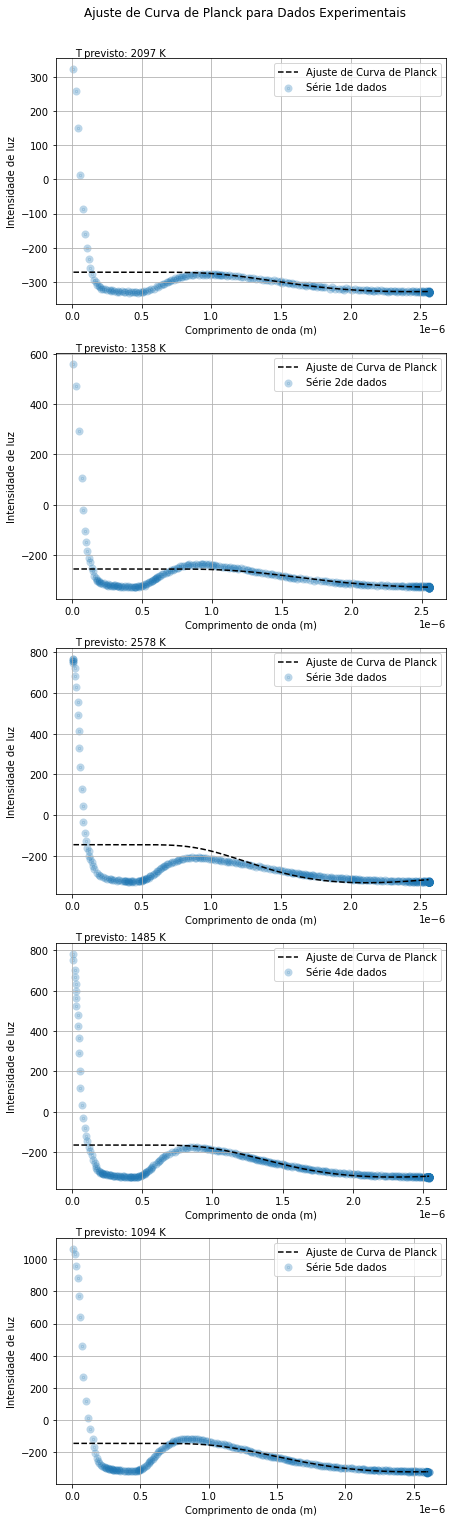

In [9]:
# Plotar dados com função prevista

fig, axs = plt.subplots(5, 1, figsize=(7,24))
fig.suptitle('Ajuste de Curva de Planck para Dados Experimentais')
fig.subplots_adjust(top=0.95)

for i in range(0,5):
    axs[i].scatter(xdata[i], y[i], label='Série '+str(i+1)+'de dados', 
               marker='.', linewidths=5, alpha=0.3)
    axs[i].plot(xdata[i], ypred[i], label='Ajuste de Curva de Planck',
                ls='--', color='black')
    axs[i].annotate('T previsto: {:.0f} K'.format(params[i][2]), xy=(0.05, 1.01), xycoords='axes fraction')
    axs[i].set_xlabel('Comprimento de onda (m)')
    axs[i].set_ylabel('Intensidade de luz')
    axs[i].legend()
    axs[i].grid()

plt.show()
fig.savefig('adj.png', bbox_inches='tight')